<a href="https://colab.research.google.com/github/FrederickAlmeida/FashionMNIST-models-comparison/blob/main/ListaPraticaMLPConv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**LISTA PRÁTICA DAS UNIDADES 1 E 2**

Pode ser feita com o grupo do projeto. Recomendo pair/group programming para que todos vejam um pouco de todas as partes.


Treine e avalie 4 modelos de classificação para a base de dados do FashionMNIST (https://www.kaggle.com/datasets/zalando-research/fashionmnist,
https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html).



1.   Um modelo base que não seja uma rede neural, como _decision tree, xgboost, random forest_, etc. Recomendação: use o sklearn (https://scikit-learn.org/).

2.   Uma MLP

3. Uma rede convolucional criada por ti. Recomendação: https://pytorch.org/

4. Use um modelo pré treinado já consolidado na literatura para fazer _transfer learning_. Recomendações: https://pytorch.org/hub/pytorch_vision_vgg/


Compare os resultados dos modelos:
* plote gráficos que mostrem as acurácias de cada modelo
* Indique qual foi a classe na qual o modelo teve pior performance (indique qual métrica usou para concluir isso e faça para cada modelo)
* argumente qual o melhor modelo levando em consideração o tempo de execução e acurácia.

Recomendação use:
https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html .



Recomendação:

Faça um template de treino, validação e teste que funcione para uma API de modelo.

Crie a API para cada modelo que será usado e use o template

# Imports e Downloads

In [1]:
# modelagem e dados
from sklearn.ensemble import RandomForestClassifier

import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils import data
import joblib
import torch.nn.functional as F
from torch.utils.data import DataLoader

# avaliação
from torchsummary import summary
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor()
])

In [3]:
train_ds = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=augmentation_transforms
)

test_ds = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=augmentation_transforms
)

100%|██████████| 26421880/26421880 [00:10<00:00, 2578382.27it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 138233.82it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2550270.45it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21722612.67it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
length = len(train_ds)
len_val = int(0.15 * length)
len_train = length - len_val
train_ds, val_ds = data.random_split(train_ds, [len_train, len_val])

In [5]:
len_train, len_val, len(test_ds)

(51000, 9000, 10000)

In [6]:
BATCH_SIZE = 128
NUM_WORKERS = 2

train_dl = data.DataLoader(
    train_ds, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True
)

val_dl = data.DataLoader(
    val_ds, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True
)

test_dl = data.DataLoader(
    test_ds, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True
)

In [7]:
instances, targets = next(iter(train_dl))
instances.shape, targets.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

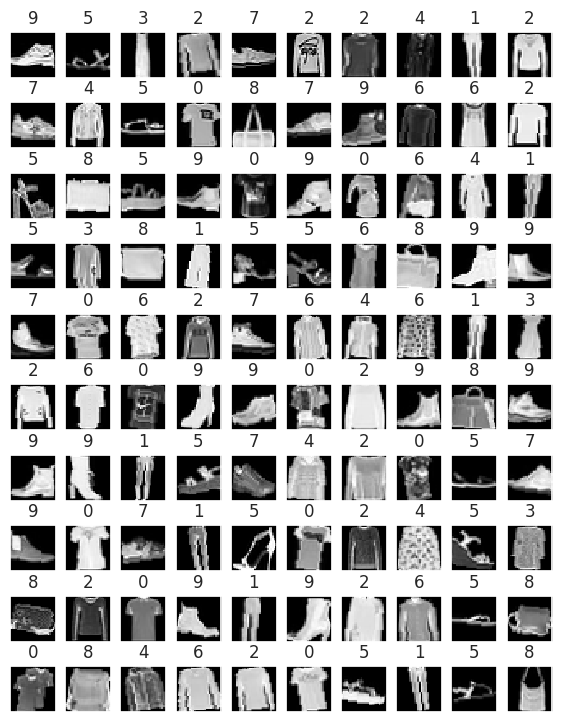

In [8]:
w = 10
fig, ax = plt.subplots(w, w, figsize=(7, 9))
for i in range(w):
    for j in range(w):
        ax[i][j].imshow(instances[i * w + j].permute(1, 2, 0), cmap="gray", interpolation="None")
        label = targets[i * w + j].item()
        ax[i][j].set_title(label)
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

# Funções de treinamento

In [9]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def train_step(model, train_dl, loss_fn, optimizer, device):
  # ativar modo de treino
  model.train()

  train_loss = AverageMeter()
  for train_instances, instance_labels in train_dl:
    # mover o lote e os rotulos para o mesmo dispositivo do modelo
    train_instances = train_instances.to(device)
    instance_labels = instance_labels.to(device)

    # fazer previsão com o modelo
    logits = model(train_instances)

    # zerar os gradientes para evitar acumular
    optimizer.zero_grad()

    # calcular função de perda
    loss = loss_fn(logits, instance_labels)
    train_loss.update(loss.item(), len(train_instances))

    # backpropagation para obter gradientes
    loss.backward()

    # aplicar a atualização dos parametros da rede baseado nos gradientes
    optimizer.step()
  return train_loss.avg

In [11]:
def validation_step(model, val_dl, loss_fn, device):
  # ativar modo de avaliação
  model.eval()

  val_loss = AverageMeter()
  # desativar computação de gradientes
  with torch.no_grad():
    for val_instances, instance_labels in val_dl:
      # mover o lote e os rotulos para o mesmo dispositivo do modelo
      val_instances = val_instances.to(device)
      instance_labels = instance_labels.to(device)

      # fazer previsão com o modelo
      logits = model(val_instances)

      # calcular função de perda
      loss = loss_fn(logits, instance_labels)
      val_loss.update(loss.item(), len(val_instances))
  return val_loss.avg

In [12]:
def train(model, train_dl, val_dl, loss_fn, optimizer, device, EPOCHS):
  history = {
    "train_loss": [],
    "val_loss": []
  }

  update_graph = EPOCHS//5
  for epoch in range(1, EPOCHS+1):
    train_loss = train_step(model, train_dl, loss_fn, optimizer, device)
    val_loss = validation_step(model, val_dl, loss_fn, device)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)

    print(f"Epoch {epoch}/{EPOCHS}")
    print(f"Train loss: {round(train_loss, 6):<7}")
    print(f"Valid. loss: {round(val_loss, 6):<7}\n")

  # mostrar apenas 30 valores de loss, para a escala do gráfico não ficar muito pequena
  update_graph = EPOCHS//30
  if update_graph < 1:
    update_graph = 1

  # plotar o gráfico de loss
  fig = plt.figure()
  plt.title("Cross entropy loss")
  plt.plot(history["train_loss"][::update_graph], c="g", label="train")
  plt.plot(history["val_loss"][::update_graph], c="r", label="valid")
  plt.legend()

In [13]:
import torch
import torch.nn.functional as F
from sklearn.metrics import classification_report

def test(model, dataset, device):
    all_probs = []
    all_preds = []
    all_targets = []
    wrong_index = []
    wrong_labels = []
    wrong_preds = []
    total_corrects = 0
    total_n = 0
    model.eval()
    with torch.no_grad():
        for instances, labels in dataset:

            instances = instances.to(device)
            labels = labels.to(device)


            logits = model(instances)
            probabilities = F.softmax(logits, 1)
            preds = torch.argmax(probabilities, 1)

            total_corrects += (preds == labels).sum().item()
            total_n += len(instances)


            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    wrong_index.append(instances[i].cpu())
                    wrong_labels.append(labels[i].cpu())
                    wrong_preds.append(preds[i].cpu())


            all_preds.append(preds.unsqueeze(-1).cpu())
            all_targets.append(labels.cpu())
            all_probs.append(probabilities.cpu())

    preds = torch.cat(all_preds).numpy()
    targets = torch.cat(all_targets).numpy()
    labels = [str(i) for i in range(10)]


    print(classification_report(targets, preds, target_names=labels, zero_division=0, digits=4))

    acuracia = total_corrects / total_n
    return acuracia, wrong_index, wrong_labels, wrong_preds


In [14]:
def display_misclassified_images(images, true_labels, predicted_labels, num_images=10):
    plt.figure(figsize=(15, 15))
    for i in range(min(num_images, len(images))):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"True: {true_labels[i]}, Pred: {predicted_labels[i]}")
        plt.axis('off')
    plt.show()

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Modelo base

In [17]:
# processar os dados para que se tornem tensores de 1 dimensão, a fim de utilizar random forest
def preprocess(dataset):
    LENGTH = len(dataset)
    loader = torch.utils.data.DataLoader(dataset, batch_size=LENGTH, shuffle=False)

    for data, labels in loader:
        data = data.numpy().reshape(LENGTH, -1)
        labels = labels.numpy()
        break

    data_transformed = data / 255.0

    return data_transformed, labels

In [ ]:
X_train, y_train = preprocess(train_ds)
X_val, y_val = preprocess(val_ds)
X_test, y_test = preprocess(test_ds)

In [ ]:
X_train.shape, y_train.shape

((51000, 784), (51000,))

In [ ]:
type(X_train)

numpy.ndarray

In [ ]:
def train_forest(X_train, y_train, X_val, y_val):
    best_model = 0

    for estimators in range(100, 1001, 100):
        classifier = RandomForestClassifier(n_estimators=estimators, random_state=1)

        classifier.fit(X_train, y_train)

        predictions = classifier.predict(X_val)
        accuracy = accuracy_score(y_val, predictions)
        print(f"estimators = {estimators}, accuracy = {accuracy:.4f}")

        if (accuracy > best_model):
            joblib.dump(classifier, 'random_forest_model.joblib')
            best_model = accuracy

In [ ]:
train_forest(X_train, y_train, X_val, y_val)

estimators = 100, accuracy = 0.8101
estimators = 200, accuracy = 0.8127
estimators = 300, accuracy = 0.8129
estimators = 400, accuracy = 0.8140
estimators = 500, accuracy = 0.8143
estimators = 600, accuracy = 0.8150
estimators = 700, accuracy = 0.8149
estimators = 800, accuracy = 0.8158
estimators = 900, accuracy = 0.8147
estimators = 1000, accuracy = 0.8149


In [ ]:
# carregando o melhor modelo
rf_classifier = joblib.load('random_forest_model.joblib')

In [ ]:
predictions = rf_classifier.predict(X_test)

print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

           0     0.7650    0.7910    0.7778      1000
           1     0.9863    0.9380    0.9616      1000
           2     0.6409    0.7140    0.6755      1000
           3     0.7914    0.8650    0.8266      1000
           4     0.6765    0.7090    0.6924      1000
           5     0.9422    0.8960    0.9185      1000
           6     0.5626    0.4180    0.4796      1000
           7     0.8763    0.9000    0.8880      1000
           8     0.9310    0.9450    0.9380      1000
           9     0.9102    0.9320    0.9209      1000

    accuracy                         0.8108     10000
   macro avg     0.8082    0.8108    0.8079     10000
weighted avg     0.8082    0.8108    0.8079     10000



# MLP

In [18]:
class MLP(nn.Module):
  def __init__(self, n_classes, dropout_prob=0.5):
    super().__init__()

    self.flatten = nn.Flatten()

    self.dropout = nn.Dropout(dropout_prob)

    # adicionando uma camada de 512 neuronios no começo
    self.mlp = nn.Sequential(
        nn.Linear(784, 1024),
        nn.ReLU(),
        self.dropout,
        nn.Linear(1024, 512),
        nn.ReLU(),
        self.dropout,
        nn.Linear(512, 256),
        nn.ReLU(),
        self.dropout,
        nn.Linear(256, 128),
        nn.ReLU(),
        self.dropout,
        nn.Linear(128, 64),
        nn.ReLU(),
        self.dropout,
        nn.Linear(64, 32),
        nn.ReLU(),
        self.dropout,
        nn.Linear(32, 16),
        nn.ReLU(),
        self.dropout,
        nn.Linear(16, 10)
    )

  def forward(self, x):
    x_flat = self.flatten(x)
    logits = self.mlp(x_flat)
    return logits

In [19]:
import torch.nn.init as init

def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            m.bias.data.fill_(0.0)

In [20]:
modelMLP = MLP(10, dropout_prob=0.3).to(device)
modelMLP.apply(init_weights)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.3, inplace=False)
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=128, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.3, inplace=False)
    (15): Linear(in_features=64, out_features=32, bias=True)
    (16): ReLU()
    (17): Dropout(p=0.3, inplace=False)
    (18): Linear(in_features=32, out_features=16, bias=True)
    (19): ReLU()
    (20): Dropout(p=0.3, inplace=False)
    (21): Linear(in_features=16, out_features=10, bias=Tru

In [21]:
LEARNING_RATE = 0.001
EPOCHS = 30
optimizer = torch.optim.Adam(modelMLP.parameters(), lr=LEARNING_RATE)
loss_fn = torch.nn.CrossEntropyLoss()

Epoch 1/30
Train loss: 1.855675
Valid. loss: 1.061137

Epoch 2/30
Train loss: 1.18049
Valid. loss: 0.873225

Epoch 3/30
Train loss: 1.018726
Valid. loss: 0.865042

Epoch 4/30
Train loss: 0.942448
Valid. loss: 0.733552

Epoch 5/30
Train loss: 0.894711
Valid. loss: 0.743538

Epoch 6/30
Train loss: 0.864508
Valid. loss: 0.727045

Epoch 7/30
Train loss: 0.844047
Valid. loss: 0.686662

Epoch 8/30
Train loss: 0.82466
Valid. loss: 0.684034

Epoch 9/30
Train loss: 0.802724
Valid. loss: 0.654898

Epoch 10/30
Train loss: 0.789544
Valid. loss: 0.644094

Epoch 11/30
Train loss: 0.780714
Valid. loss: 0.640748

Epoch 12/30
Train loss: 0.76498
Valid. loss: 0.626261

Epoch 13/30
Train loss: 0.748813
Valid. loss: 0.603999

Epoch 14/30
Train loss: 0.741951
Valid. loss: 0.615035

Epoch 15/30
Train loss: 0.731631
Valid. loss: 0.601359

Epoch 16/30
Train loss: 0.727709
Valid. loss: 0.594871

Epoch 17/30
Train loss: 0.71311
Valid. loss: 0.586018

Epoch 18/30
Train loss: 0.728435
Valid. loss: 0.591954

Epoch

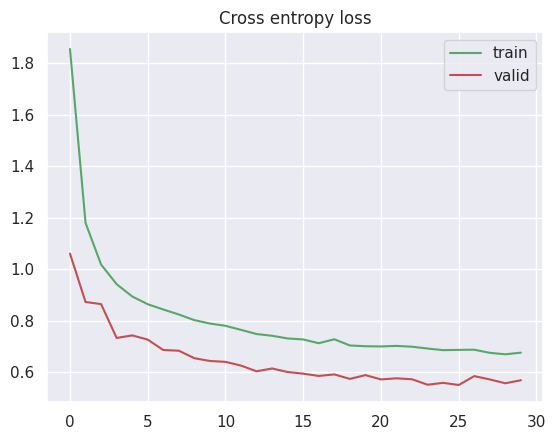

In [22]:
train(modelMLP, train_dl, val_dl, loss_fn, optimizer, device, EPOCHS)

In [24]:
result = test(modelMLP, test_dl, device)

              precision    recall  f1-score   support

           0     0.6919    0.8580    0.7661      1000
           1     0.9884    0.9390    0.9631      1000
           2     0.5158    0.7350    0.6062      1000
           3     0.8187    0.8580    0.8379      1000
           4     0.6485    0.7010    0.6737      1000
           5     0.9279    0.9260    0.9269      1000
           6     0.2941    0.0550    0.0927      1000
           7     0.8643    0.9430    0.9020      1000
           8     0.9085    0.9630    0.9350      1000
           9     0.9696    0.8920    0.9292      1000

    accuracy                         0.7870     10000
   macro avg     0.7628    0.7870    0.7633     10000
weighted avg     0.7628    0.7870    0.7633     10000



# Rede Convolucional

## Arquitetura da rede escolhida

Escolhemos tal arquitetura customizada por resultados excelentes no dataset MNIST de um projeto de redes neurais, que embora diferente, achamos interessante utilizar aqui.

In [ ]:
# Definição da arquitetura da CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Camada convolucional 1
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)  # Conv layer com 16 filtros, kernel 5x5
        self.bn1 = nn.BatchNorm2d(16)  # Batch normalization para a primeira camada convolucional
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling com kernel 2x2 e stride 2

        # Camada convolucional 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=1)  # Conv layer com 32 filtros, kernel 5x5
        self.bn2 = nn.BatchNorm2d(32)  # Batch normalization para a segunda camada convolucional

        # Camada convolucional 3
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)  # Conv layer com 64 filtros, kernel 5x5
        self.bn3 = nn.BatchNorm2d(64)  # Batch normalization para a terceira camada convolucional

        # Camada convolucional 4
        self.conv4 = nn.Conv2d(64, 90, kernel_size=5, stride=1, padding=2)  # Conv layer com 90 filtros, kernel 5x5
        self.bn4 = nn.BatchNorm2d(90)  # Batch normalization para a quarta camada convolucional

        # Camada de flatten
        self.flatten = nn.Flatten()  # Flatten layer para converter tensor 4D em 2D

        # Camada totalmente conectada 1
        self.fc1 = nn.Linear(90 * 3 * 3, 256)  # Fully connected layer com 256 unidades
        self.dropout1 = nn.Dropout(0.3)  # Dropout layer com 30% de dropout

        # Camada totalmente conectada 2
        self.fc2 = nn.Linear(256, 128)  # Fully connected layer com 128 unidades
        self.dropout2 = nn.Dropout(0.3)  # Dropout layer com 30% de dropout

        # Camada de saída
        self.fc3 = nn.Linear(128, 10)  # Fully connected layer com 10 unidades (saída)

    def forward(self, x):
        # Forward pass
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Conv1 -> BatchNorm1 -> ReLU -> Pooling
        x = F.relu(self.bn2(self.conv2(x)))  # Conv2 -> BatchNorm2 -> ReLU
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Conv3 -> BatchNorm3 -> ReLU -> Pooling
        x = self.pool(F.relu(self.bn4(self.conv4(x))))  # Conv4 -> BatchNorm4 -> ReLU -> Pooling
        x = self.flatten(x)  # Flatten para converter tensor 4D em 2D
        x = F.relu(self.fc1(x))  # Fully Connected 1 -> ReLU
        x = self.dropout1(x)  # Dropout após FC1
        x = F.relu(self.fc2(x))  # Fully Connected 2 -> ReLU
        x = self.dropout2(x)  # Dropout após FC2
        x = self.fc3(x)  # Fully Connected 3 (saída)
        return x


In [ ]:
# Função de inicialização dos pesos

def he(m):
    if type(m) == nn.Conv2d or type(m) == nn.Linear:
        nn.init.kaiming_normal_(m.weight)



In [ ]:
# Escolhendo a LossFunction e o otimizador, no caso escolhemos o Adam por resultados muito interessantes em testes

criterion = nn.CrossEntropyLoss()


Epoch 1/30
Train loss: 0.755865
Valid. loss: 0.509109

Epoch 2/30
Train loss: 0.513925
Valid. loss: 0.422177

Epoch 3/30
Train loss: 0.448107
Valid. loss: 0.387935

Epoch 4/30
Train loss: 0.409985
Valid. loss: 0.366821

Epoch 5/30
Train loss: 0.390978
Valid. loss: 0.377736

Epoch 6/30
Train loss: 0.372246
Valid. loss: 0.339311

Epoch 7/30
Train loss: 0.353698
Valid. loss: 0.34472

Epoch 8/30
Train loss: 0.346267
Valid. loss: 0.344134

Epoch 9/30
Train loss: 0.329754
Valid. loss: 0.337263

Epoch 10/30
Train loss: 0.322922
Valid. loss: 0.32269

Epoch 11/30
Train loss: 0.312108
Valid. loss: 0.339811

Epoch 12/30
Train loss: 0.305082
Valid. loss: 0.304854

Epoch 13/30
Train loss: 0.297357
Valid. loss: 0.306015

Epoch 14/30
Train loss: 0.293473
Valid. loss: 0.290271

Epoch 15/30
Train loss: 0.289944
Valid. loss: 0.303868

Epoch 16/30
Train loss: 0.277707
Valid. loss: 0.311774

Epoch 17/30
Train loss: 0.277618
Valid. loss: 0.290703

Epoch 18/30
Train loss: 0.274671
Valid. loss: 0.283813

Epo

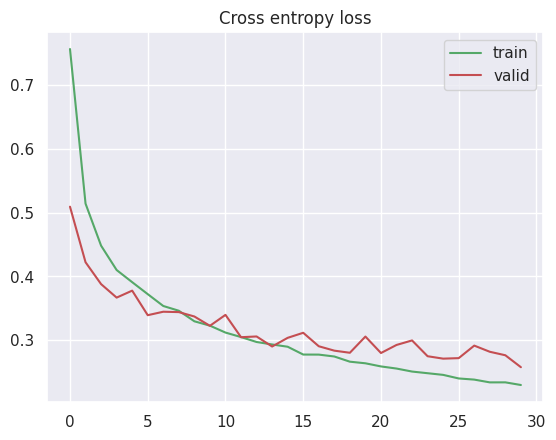

In [ ]:
CNNModel = CNN()
CNNModel.apply(he) # aplicando a inicialização
optimizer = optim.Adam(CNNModel.parameters(), lr=0.001)
CNNModel.to(device)
train(CNNModel, train_dl, val_dl, criterion, optimizer, device, 30)

In [ ]:
# Example usage:
accuracy, misclassified_images, misclassified_labels, misclassified_preds = test(CNNModel, test_dl, device)


              precision    recall  f1-score   support

           0     0.8820    0.8070    0.8428      1000
           1     1.0000    0.9750    0.9873      1000
           2     0.8338    0.8880    0.8600      1000
           3     0.8919    0.9320    0.9115      1000
           4     0.8761    0.8060    0.8396      1000
           5     0.9848    0.9710    0.9778      1000
           6     0.7148    0.7720    0.7423      1000
           7     0.9270    0.9780    0.9518      1000
           8     0.9859    0.9820    0.9840      1000
           9     0.9772    0.9410    0.9587      1000

    accuracy                         0.9052     10000
   macro avg     0.9073    0.9052    0.9056     10000
weighted avg     0.9073    0.9052    0.9056     10000



In [ ]:
def display_misclassified_images(images, true_labels, predicted_labels, num_images=10):
    plt.figure(figsize=(15, 15))
    for i in range(min(num_images, len(images))):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"True: {true_labels[i]}, Pred: {predicted_labels[i]}")
        plt.axis('off')
    plt.show()


              precision    recall  f1-score   support

           0     0.8168    0.7760    0.7959      1000
           1     0.9569    0.9770    0.9668      1000
           2     0.7588    0.7140    0.7357      1000
           3     0.8037    0.8720    0.8365      1000
           4     0.6394    0.8530    0.7309      1000
           5     0.9390    0.9540    0.9464      1000
           6     0.6594    0.4530    0.5370      1000
           7     0.9243    0.9040    0.9141      1000
           8     0.9772    0.9440    0.9603      1000
           9     0.9335    0.9540    0.9436      1000

    accuracy                         0.8401     10000
   macro avg     0.8409    0.8401    0.8367     10000
weighted avg     0.8409    0.8401    0.8367     10000



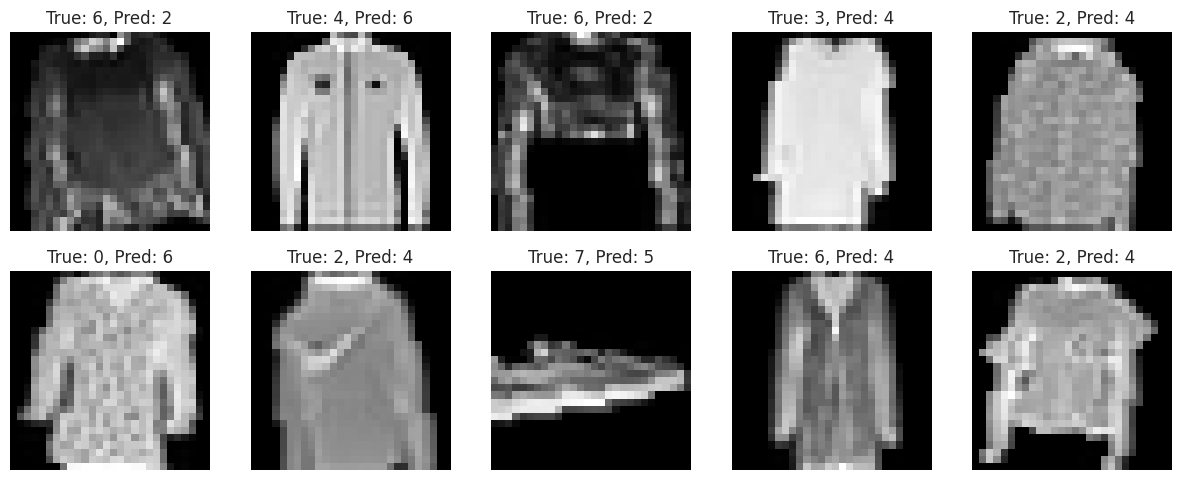

In [ ]:
# Print de imagens classificadas errôneamente

accuracy, misclassified_images, misclassified_labels, misclassified_preds = test(CNNModel, test_dl, device)
display_misclassified_images(misclassified_images, misclassified_labels, misclassified_preds, num_images=10)



# Rede Convolucional consolidada

Ajustando as imagems para ter dimensão 3x224x224, dimensão na qual as arquiteturas vgg foram treinadas

In [ ]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

train_ds_vgg = datasets.FashionMNIST(
    root='data/vgg',
    train=True,
    download=True,
    transform=transform
)

test_ds_vgg = datasets.FashionMNIST(
    root='data/vgg',
    train=False,
    download=True,
    transform=transform
)

length = len(train_ds_vgg)
len_val = int(0.15 * length)
len_train = length - len_val
train_ds_vgg, val_ds_vgg = data.random_split(train_ds_vgg, [len_train, len_val])

In [ ]:
BATCH_SIZE = 128
NUM_WORKERS = 2

train_dl_vgg = data.DataLoader(
    train_ds_vgg, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True
)

val_dl_vgg = data.DataLoader(
    val_ds_vgg, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True
)

test_dl_vgg = data.DataLoader(
    test_ds_vgg, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True
)

In [ ]:
instances, targets = next(iter(train_dl_vgg))
instances.shape, targets.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

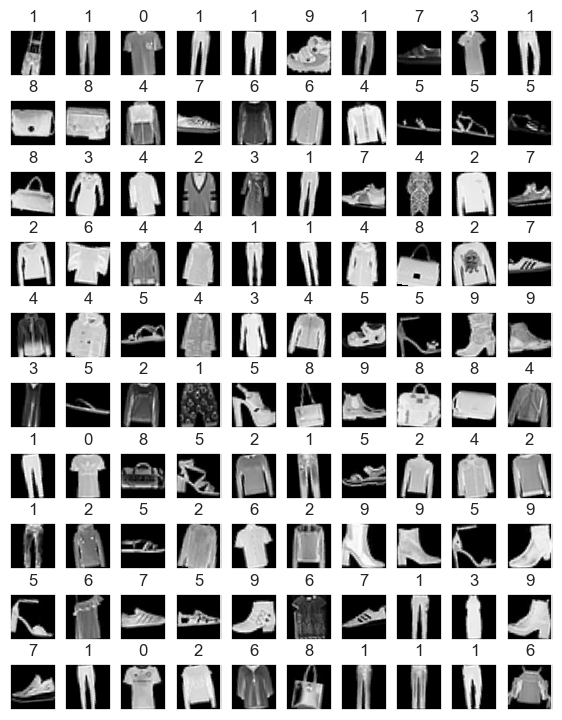

In [ ]:
w = 10
fig, ax = plt.subplots(w, w, figsize=(7, 9))
for i in range(w):
    for j in range(w):
        ax[i][j].imshow(instances[i * w + j].permute(1, 2, 0), cmap="gray", interpolation="None")
        label = targets[i * w + j].item()
        ax[i][j].set_title(label)
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

In [ ]:
vgg16_model = models.vgg16(pretrained=True)

c:\Users\T-Gamer\miniconda3\envs\redesneurais\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\T-Gamer\miniconda3\envs\redesneurais\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
print(vgg16_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
vgg16_model.classifier[6] = torch.nn.Linear(vgg16_model.classifier[6].in_features, 10)

print(vgg16_model.classifier[6])

Linear(in_features=4096, out_features=10, bias=True)


In [ ]:
for param in vgg16_model.features.parameters():
    param.requires_grad = False

for param in vgg16_model.classifier.parameters():
    param.requires_grad = False

for param in vgg16_model.classifier[6].parameters():
    param.requires_grad = True

In [ ]:
for name, param in vgg16_model.named_parameters():
    print(f"{name} is {'not ' if param.requires_grad else ''}frozen")

features.0.weight is frozen
features.0.bias is frozen
features.2.weight is frozen
features.2.bias is frozen
features.5.weight is frozen
features.5.bias is frozen
features.7.weight is frozen
features.7.bias is frozen
features.10.weight is frozen
features.10.bias is frozen
features.12.weight is frozen
features.12.bias is frozen
features.14.weight is frozen
features.14.bias is frozen
features.17.weight is frozen
features.17.bias is frozen
features.19.weight is frozen
features.19.bias is frozen
features.21.weight is frozen
features.21.bias is frozen
features.24.weight is frozen
features.24.bias is frozen
features.26.weight is frozen
features.26.bias is frozen
features.28.weight is frozen
features.28.bias is frozen
classifier.0.weight is frozen
classifier.0.bias is frozen
classifier.3.weight is frozen
classifier.3.bias is frozen
classifier.6.weight is not frozen
classifier.6.bias is not frozen


Epoch 1/10
Train loss: 0.684768
Valid. loss: 0.490353

Epoch 2/10
Train loss: 0.574647
Valid. loss: 0.4652 

Epoch 3/10
Train loss: 0.559325
Valid. loss: 0.448857

Epoch 4/10
Train loss: 0.551107
Valid. loss: 0.443323

Epoch 5/10
Train loss: 0.54757
Valid. loss: 0.438118

Epoch 6/10
Train loss: 0.543342
Valid. loss: 0.435711

Epoch 7/10
Train loss: 0.545725
Valid. loss: 0.433446

Epoch 8/10
Train loss: 0.545231
Valid. loss: 0.455484

Epoch 9/10
Train loss: 0.540827
Valid. loss: 0.426885

Epoch 10/10
Train loss: 0.53716
Valid. loss: 0.422553



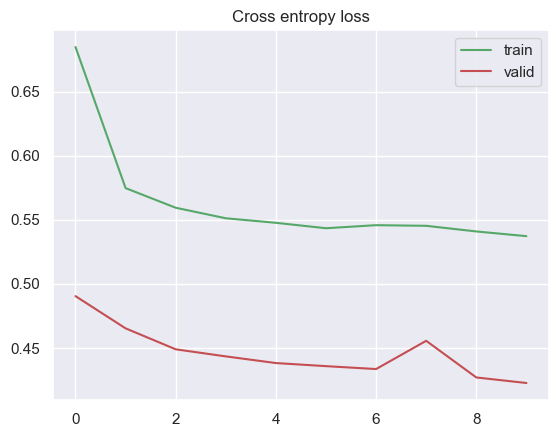

In [ ]:
vgg16_model.to(device)
LEARNING_RATE = 0.001
EPOCHS = 10
optimizer = torch.optim.Adam(vgg16_model.parameters(), lr=LEARNING_RATE)
loss_fn = torch.nn.CrossEntropyLoss()

train(vgg16_model, train_dl_vgg, val_dl_vgg, loss_fn, optimizer, device, EPOCHS)

In [ ]:
torch.save(vgg16_model.state_dict(), 'vgg16.pth')

In [ ]:
test(vgg16_model, test_dl_vgg, device)

              precision    recall  f1-score   support

           0     0.8231    0.7540    0.7871      1000
           1     0.9938    0.9600    0.9766      1000
           2     0.8025    0.7600    0.7807      1000
           3     0.7203    0.8910    0.7966      1000
           4     0.7136    0.7300    0.7217      1000
           5     0.9439    0.9260    0.9349      1000
           6     0.6101    0.5430    0.5746      1000
           7     0.9155    0.9100    0.9127      1000
           8     0.9573    0.9630    0.9601      1000
           9     0.9212    0.9580    0.9392      1000

    accuracy                         0.8395     10000
   macro avg     0.8401    0.8395    0.8384     10000
weighted avg     0.8401    0.8395    0.8384     10000



0.8395

# Comparação